# Machine Learning Portfolio 2

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv("train.csv", parse_dates=['date_hour'])
df_test = pd.read_csv("test.csv", parse_dates=['date_hour'])
sample = pd.read_csv("sample_submission.csv")

In [13]:
class date_time_features:
    def __init__(self, data):
        self.dfh = data.set_index('date_hour')
        self.dfh = self.dfh.reset_index()
        self.dfh["Year"] = self.dfh["date_hour"].dt.year
        self.dfh["Month"] = self.dfh["date_hour"].dt.month
        self.dfh["Day_of_Week"] = self.dfh["date_hour"].dt.dayofweek
        self.dfh["Day_name"] = self.dfh["date_hour"].dt.day_name()
        self.dfh["Hour"] = self.dfh["date_hour"].dt.hour
        self.dfh["Week"] = self.dfh["date_hour"].dt.isocalendar().week
        self.dfh.set_index('date_hour', inplace=True)

## EDA

### Train set

In [16]:
train = date_time_features(data=df_train)
display(train.dfh.info(), train.dfh.describe(), train.dfh.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   holiday      16637 non-null  int64  
 1   weathersit   16637 non-null  int64  
 2   temp         16637 non-null  float64
 3   atemp        16637 non-null  float64
 4   hum          16637 non-null  float64
 5   windspeed    16637 non-null  float64
 6   cnt          16637 non-null  int64  
 7   Year         16637 non-null  int64  
 8   Month        16637 non-null  int64  
 9   Day_of_Week  16637 non-null  int64  
 10  Day_name     16637 non-null  object 
 11  Hour         16637 non-null  int64  
 12  Week         16637 non-null  UInt32 
dtypes: UInt32(1), float64(4), int64(7), object(1)
memory usage: 1.7+ MB


None

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Year,Month,Day_of_Week,Hour,Week
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009,2011.480375,6.294164,3.008776,11.547875,25.614895
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755,0.499630,3.310969,1.998538,6.914199,14.466678
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000,2011.000000,3.000000,1.000000,6.000000,13.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000,2011.000000,6.000000,3.000000,12.000000,26.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000,2012.000000,9.000000,5.000000,18.000000,38.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,2012.000000,12.000000,6.000000,23.000000,52.000000


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Year,Month,Day_of_Week,Day_name,Hour,Week
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,5,Saturday,0,52
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,5,Saturday,1,52
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,5,Saturday,2,52
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,5,Saturday,3,52
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,5,Saturday,4,52


### Test set

In [147]:
test = date_time_features(data=df_test)
display(test.dfh.info(), test.dfh.describe(), test.dfh.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 2012-12-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   holiday      456 non-null    int64  
 1   weathersit   456 non-null    int64  
 2   temp         456 non-null    float64
 3   atemp        456 non-null    float64
 4   hum          456 non-null    float64
 5   windspeed    456 non-null    float64
 6   Year         456 non-null    int64  
 7   Month        456 non-null    int64  
 8   Day_of_Week  456 non-null    int64  
 9   Day_name     456 non-null    object 
 10  Hour         456 non-null    int64  
 11  Week         456 non-null    UInt32 
dtypes: UInt32(1), float64(4), int64(6), object(1)
memory usage: 45.0+ KB


None

,holiday,weathersit,temp,atemp,hum,windspeed,Year,Month,Day_of_Week,Hour,Week
count,456.0,456.000000,456.000000,456.000000,456.000000,456.000000,456.0,456.0,456.000000,456.000000,456.000000
mean,0.0,1.592105,0.360132,0.363691,0.714868,0.157639,2012.0,12.0,2.947368,11.500000,49.578947
std,0.0,0.607882,0.079432,0.076354,0.177732,0.106499,0.0,0.0,2.091709,6.929789,0.878508
min,0.0,1.000000,0.160000,0.181800,0.330000,0.000000,2012.0,12.0,0.000000,0.000000,48.000000
25%,0.0,1.000000,0.300000,0.303000,0.560000,0.089600,2012.0,12.0,1.000000,5.750000,49.000000
50%,0.0,2.000000,0.360000,0.363600,0.750000,0.134300,2012.0,12.0,3.000000,11.500000,50.000000
75%,0.0,2.000000,0.400000,0.409100,0.870000,0.223900,2012.0,12.0,5.000000,17.250000,50.000000
max,0.0,3.000000,0.600000,0.621200,1.000000,0.492500,2012.0,12.0,6.000000,23.000000,51.000000


,holiday,weathersit,temp,atemp,hum,windspeed,Year,Month,Day_of_Week,Day_name,Hour,Week
date_hour,,,,,,,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,2012,12,5,Saturday,0,48
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,2012,12,5,Saturday,1,48
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2012,12,5,Saturday,2,48
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,2012,12,5,Saturday,3,48
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,2012,12,5,Saturday,4,48


- date_hour: Je hebt informatie over de periode van 1-1-2011 t/m 30-11-2012
- holiday: Vakantiedag of geen vakantiedag
- weathersit: Weersituatie:
    1. Helder, licht bewolkt, deels bewolkt
    2. Mistig , mistig en licht bewolkt
    3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte regen en zwaar bewolkt
    4. Zware regen, hagel, zware mist, sneeuw.
- temp: genormaliseerde temperatuur
- atemp: genormaliseerde gevoelstemperatuur
- hum: genormaliseerde luchtvochtigheid
- windspeed: genormaliseerde windsnelheid.

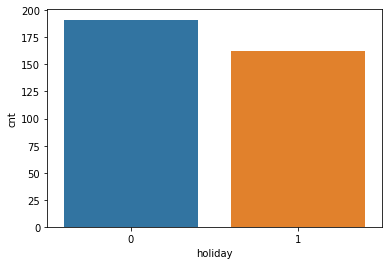

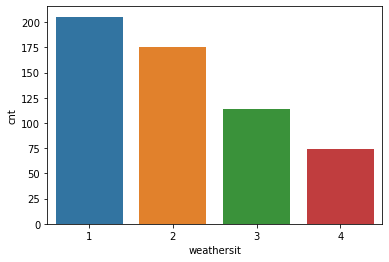

In [17]:
x_col = ["holiday","weathersit"]
for x in x_col:
    sns.barplot(data=train.dfh, x=x, y="cnt", estimator=np.mean, ci=None)
    plt.show()

Voor holidays tegen verhuur aantal, zien we dat op gemiddelijk niet verschil heeft. Dus holidays is niet van belang of het product meer of minder verhuurd wordt.  
Terwijl voor het situatie van het weer, zien we dat hoe slechter het weer is hoe minder er verhuurd wordt. Dus het weer is wel van belang.

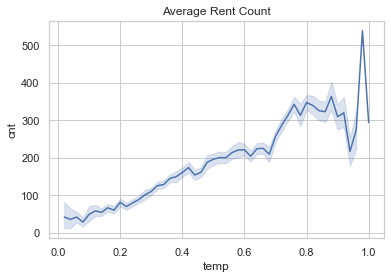

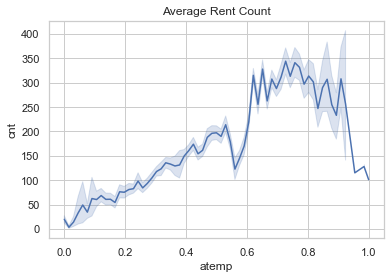

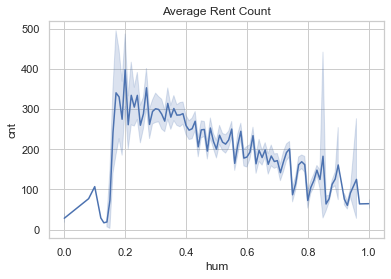

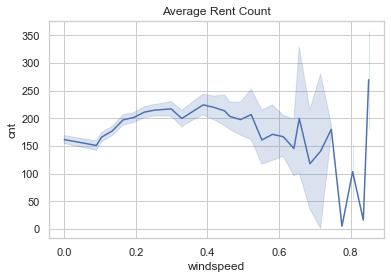

In [86]:
x_col = ["temp", "atemp", "hum", "windspeed"]

for x in x_col:
    sns.lineplot(data=train.dfh, x=x, y="cnt", estimator=np.mean)
    plt.title("Average Rent Count")
    plt.show()

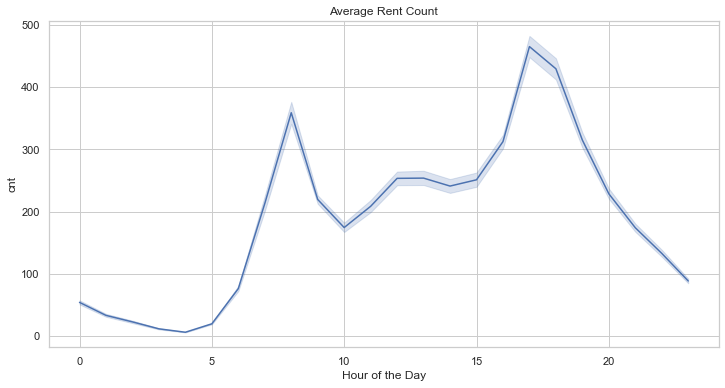

In [87]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Hour", y="cnt", estimator=np.mean)
plt.title("Average Rent Count")
plt.xlabel("Hour of the Day")
plt.show()

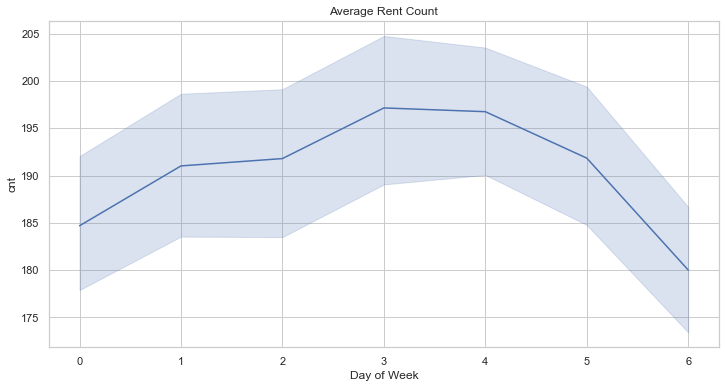

In [88]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Day_of_Week", y="cnt", estimator=np.mean)
plt.title("Average Rent Count")
plt.xlabel("Day of Week")
plt.show()

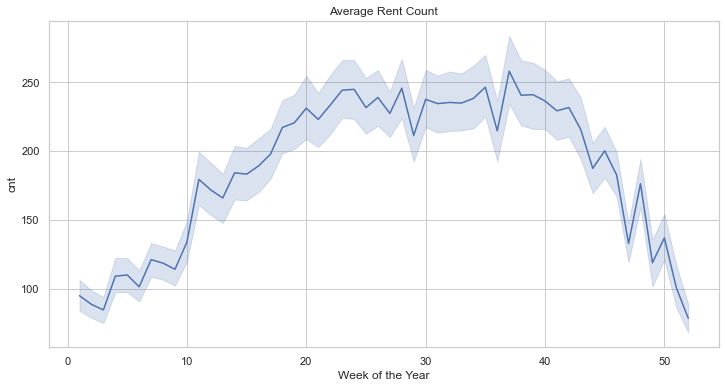

In [89]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Week", y="cnt", estimator=np.mean)
plt.title("Average Rent Count")
plt.xlabel("Week of the Year")
plt.show()

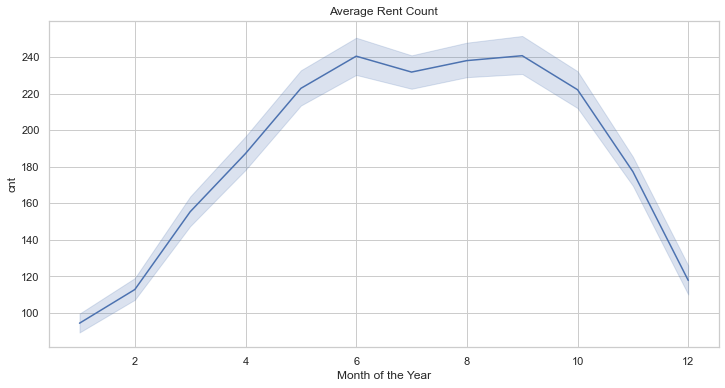

In [90]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Month", y="cnt", estimator=np.mean)
plt.title("Average Rent Count")
plt.xlabel("Month of the Year")
plt.show()

Uitleg uit de grafieken. Wat haal je eruit.

## Timeseries Feature Engineering

### FFT

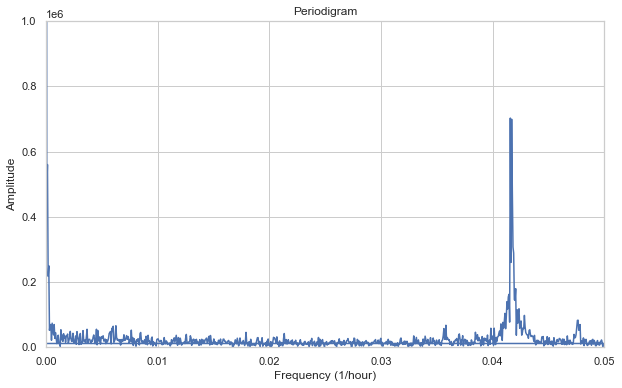

In [23]:
tijdreeks = train.dfh['cnt']
n = len(tijdreeks)
freq = np.fft.fftfreq(n,1)
fft_result = fft(tijdreeks)

plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(fft_result))
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Amplitude')
plt.xlim([0,0.05])
plt.ylim([0,1e6])
plt.title('Periodigram')
plt.grid(True)
plt.show()

In [39]:
df_fft = pd.DataFrame(np.abs(fft_result))
df_fft['freq'] = freq
hours = []
days= []
for f in freq:
    if f != 0:
        hours.append(1/f)
        days.append(1/f/24)
    else:
        hours.append(np.inf)
        days.append(np.inf)
df_fft['duur in uren'] = hours
df_fft['duur in dagen'] = days
df_fft.rename(columns={0:'amplitude'}, inplace=True)
df_fft = df_fft[(df_fft['amplitude'] > 0.4e+06)&(df_fft['freq'] > 0)]
df_fft

# dagelijks patroon en jaarlijks patroon

,amplitude,freq,duur in uren,duur in dagen
1,489864.299841,0.000060,16637.000000,693.208333
2,560236.241034,0.000120,8318.500000,346.604167
692,702799.953019,0.041594,24.041908,1.001746
694,699280.808600,0.041714,23.972622,0.998859
695,479527.144257,0.041774,23.938129,0.997422


### Lags

In [107]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

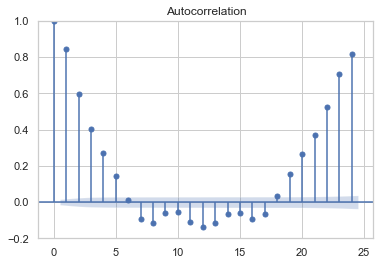

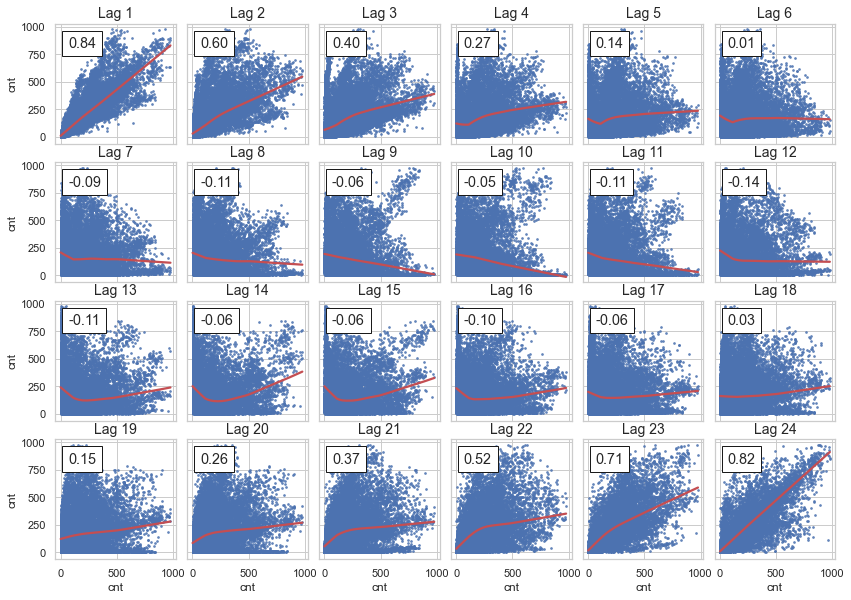

In [139]:
plot_acf(train.dfh["cnt"], lags=24)
plt.ylim(-0.2,1)
plot_lags(train.dfh["cnt"], lags=24, nrows=4)
plt.show()

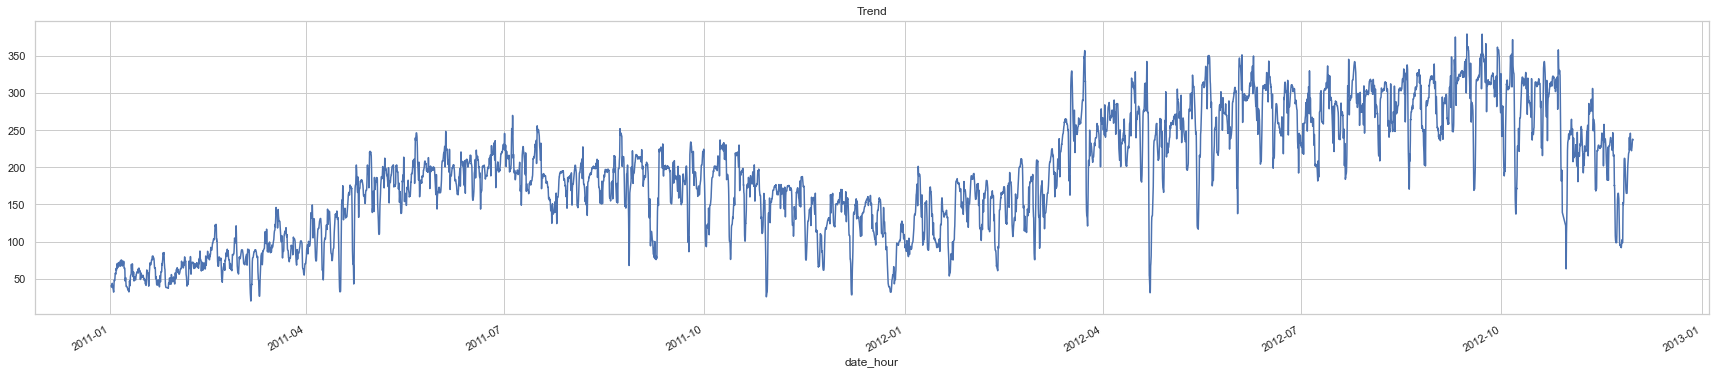

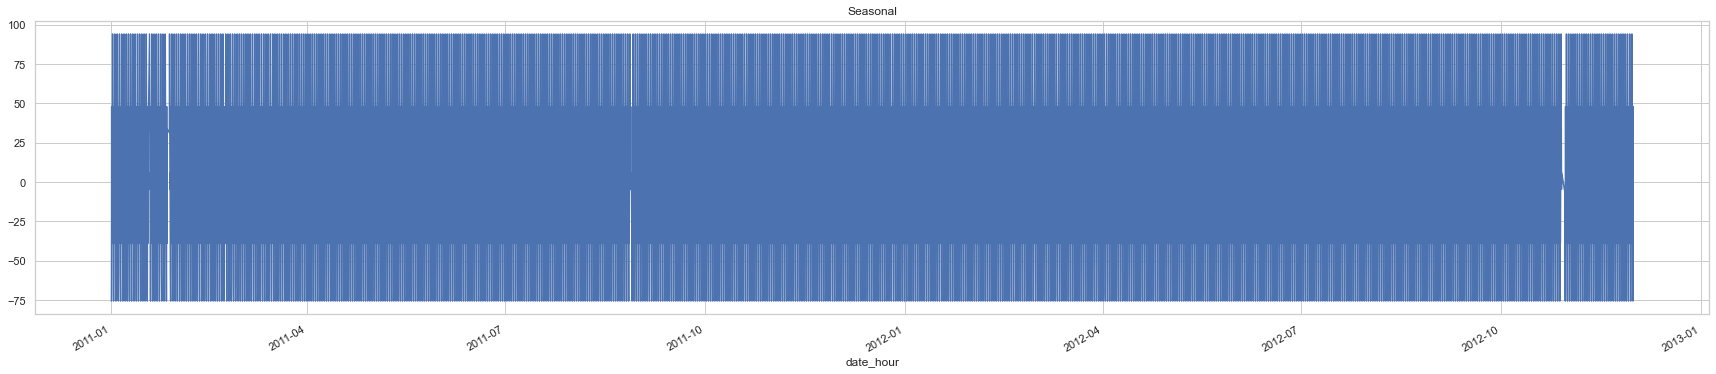

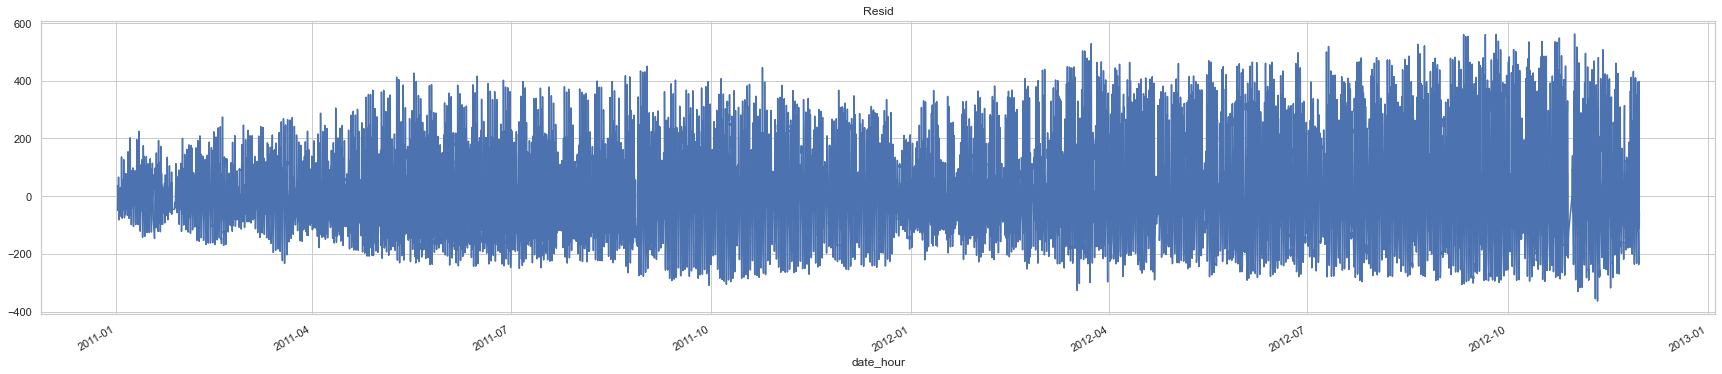

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(train.dfh['cnt'], model='additive', period=24)
plt.figure(figsize=(30,6))
plt.title("Trend")
sd.trend.plot()
plt.figure(figsize=(30,6))
plt.title("Seasonal")
sd.seasonal.plot()
plt.figure(figsize=(30,6))
plt.title("Resid")
sd.resid.plot()
plt.show()

We hebben een dagelijkse patroon, dus we kiezen 24 voor period (data in uren).  
Op het trend grafiek, van het begin van 2011 stijgt het tot in de zomer en vanaf oktober 2011 daalt het weer tot nieuw jaar. In 2012 begint het ook met een stijging, dit stijgt tot rond april 2012 en vanaf oktober daalt het ook tot nieuwe jaar.  
Het product is trending in lente en zomer.  
De seasonal grafiek ziet er bijna een hele blok uit, het patroon geeft aan dat het een herhalend dagelijkse cyclus is. 
Uit de resid grafiek zie je hoe groot de storingen zijn in de data die niet in de trend en seasonal zitten.

### Timeseries Features

In [145]:
# All columns has to be numeric. Make dummies or drop them.
df = pd.get_dummies(train.dfh, "Day_name")
X = df.drop("cnt", axis=1)
y = df["cnt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7*24, shuffle=False)

# Create fourier
# We saw that there is a Yearly and Daily pattern.
# There are other peaks very close to the Daily frequency, we'll test with different orders.
fourier = CalendarFourier(freq='A', order = 1) # A-Annual
fourier2 = CalendarFourier(freq='D', order = 1) # D-Daily

dp = DeterministicProcess(index=y_train.index, constant=False, order=1, seasonal=False,
                          additional_terms = [fourier, fourier2], drop = True)
X_train2 = dp.in_sample()
X_test2 = dp.out_of_sample(steps = len(y_test),forecast_index=y_test.index)

X_train = pd.concat([X_train, X_train2], axis=1)
X_test = pd.concat([X_test, X_test2], axis=1)
display(X_train.head(), X_test.head())

,holiday,weathersit,temp,atemp,hum,windspeed,Year,Month,Day_of_Week,Hour,...,Day_name_Saturday,Day_name_Sunday,Day_name_Thursday,Day_name_Tuesday,Day_name_Wednesday,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,2011,1,5,0,...,1,0,0,0,0,1.0,0.000000,1.000000,0.000000,1.000000
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,2011,1,5,1,...,1,0,0,0,0,2.0,0.000717,1.000000,0.258819,0.965926
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,2011,1,5,2,...,1,0,0,0,0,3.0,0.001435,0.999999,0.500000,0.866025
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,2011,1,5,3,...,1,0,0,0,0,4.0,0.002152,0.999998,0.707107,0.707107
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,2011,1,5,4,...,1,0,0,0,0,5.0,0.002869,0.999996,0.866025,0.500000


,holiday,weathersit,temp,atemp,hum,windspeed,Year,Month,Day_of_Week,Hour,...,Day_name_Saturday,Day_name_Sunday,Day_name_Thursday,Day_name_Tuesday,Day_name_Wednesday,trend,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)"
date_hour,,,,,,,,,,,,,,,,,,,,,
2012-11-23 23:00:00,0,1,0.42,0.4242,0.38,0.4478,2012,11,4,23,...,0,0,0,0,0,16470.0,-0.607626,0.794223,-0.258819,0.965926
2012-11-24 00:00:00,0,1,0.40,0.4091,0.37,0.4179,2012,11,5,0,...,1,0,0,0,0,16471.0,-0.607058,0.794658,0.000000,1.000000
2012-11-24 01:00:00,0,1,0.34,0.2879,0.42,0.4925,2012,11,5,1,...,1,0,0,0,0,16472.0,-0.606489,0.795092,0.258819,0.965926
2012-11-24 02:00:00,0,1,0.32,0.2727,0.39,0.6119,2012,11,5,2,...,1,0,0,0,0,16473.0,-0.605920,0.795525,0.500000,0.866025
2012-11-24 03:00:00,0,1,0.28,0.2576,0.41,0.3582,2012,11,5,3,...,1,0,0,0,0,16474.0,-0.605351,0.795959,0.707107,0.707107


## Modelleren

In [152]:
models_dict = {
    "lr": {
        "model":LinearRegression(),
        "params":None
    },
    "dt": {
        "model":DecisionTreeRegressor(), 
        "params":{
            "criterion":["squared_error","friedman_mse","absolute_error","poisson"],
            "splitter":["best", "random"],
            "max_depth":[None,30,35]
        }
    },
    "rf": {
        "model":RandomForestRegressor(random_state=42, n_jobs=-1), 
        "params":{"criterion":["squared_error","friedman_mse","absolute_error","poisson"],
                  "max_depth": [None,30,35]}
    },
    "gb": {
        "model":GradientBoostingRegressor(random_state=42), 
        "params":{"loss":["squared_error","absolute_error","huber","quantile"],
                  "criterion":["squared_error","friedman_mse"],
                  "max_depth":[None,30,35],
                  "learning_rate":[0.01,0.1,1.0]}
    },
    "ada": {
        "model":AdaBoostRegressor(estimator=DecisionTreeRegressor()), 
        "params":{"loss":["linear","square","exponential"],
                  "n_estimators":[50,100,150],
                  "learning_rate":[0.01, 0.1, 1.0],
                  "base_estimator__max_depth":[None, 30, 35]}
    }
              }

In [ ]:
best_models = {}
best_params = {}
best_scores = {}

for model_name, config in models.items():
    grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    
    cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    best_scores[model_name] = cross_val_scores.mean()
    
for model_name, best_model in best_models.items():
    print(f"Best model for {model_name}: {best_model}")
    print(f"Best parameters for {model_name}: {best_params[model_name]}")
    print(f"Cross-validation score for {model_name}: {best_scores[model_name]}")